In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [4]:
df[df['Rg'].notna()].head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
10,2986007,*c1ccc(-c2ccc3c(c2)C(CCCCCCC#N)(CCCCCCC#N)c2cc...,NaN,0.402397,0.487000,0.901123,28.682441
11,3013292,*CC(*)c1ccc(C(=O)O)c(C(=O)O)c1,NaN,NaN,0.171000,1.184354,13.534248
37,9231170,*CC(*)CC,NaN,NaN,0.225333,NaN,13.872913
46,11894206,*CC(*)C(=O)Oc1ccccc1C,NaN,0.357831,0.173500,1.061864,12.737463
64,16855553,*CC(*)C(=O)Oc1ccccc1,NaN,0.353941,0.196000,1.109389,13.435339


In [5]:
counts = {
    'SMILES':df['SMILES'].notna().sum(),
    'Tg': df['Tg'].notna().sum(),
    'FFV': df['FFV'].notna().sum(),
    'Tc': df['Tc'].notna().sum(),
    'Density': df['Density'].notna().sum(),
    'Rg': df['Rg'].notna().sum()
}
counts

{'SMILES': 7973, 'Tg': 511, 'FFV': 7030, 'Tc': 737, 'Density': 613, 'Rg': 614}

*CC(*)C(=O)OCCCCCCOc1ccc(-c2ccc(C#N)cc2)cc1


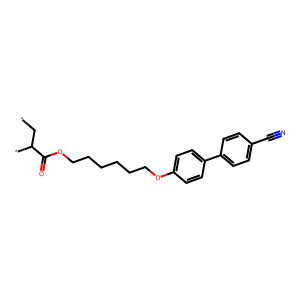

In [16]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
i = 50
print(df.loc[i, 'SMILES'])
mol = Chem.MolFromSmiles(df.loc[i, 'SMILES'])
Draw.MolToImage(mol)

In [25]:
from torch_geometric.data import Data
import torch

def mol_to_graph(smiles: str, y: float) -> Data:
    mol = Chem.MolFromSmiles(smiles)
    
    atom_features = []
    for atom in mol.GetAtoms():
            atom_features.append([
            atom.GetAtomicNum(),                      # 原子序号（C=6, O=8...）
            atom.GetTotalDegree(),                    # 键连数
            atom.GetFormalCharge(),                   # 形式电荷
            atom.GetTotalNumHs(),                     # 氢原子数（包括显式/隐式）
            int(atom.GetIsAromatic()),                # 是否为芳香性
            int(atom.GetHybridization()),             # 杂化类型（SP=0, SP2=1, ...）
            int(atom.IsInRing()),                     # 是否在环中    
        ])

    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type = bond.GetBondTypeAsDouble() # 键型

        edge_index += [[i, j], [j, i]]
        edge_attr += [[bond_type], [bond_type]]

    data = Data(
        x=torch.tensor(atom_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float),
        y=torch.tensor(y, dtype=torch.float)
    )

    return data
gometric_data = mol_to_graph(df.loc[i, 'SMILES'], df.loc[i, 'FFV'])
gometric_data

Data(x=[28, 7], edge_index=[2, 58], edge_attr=[58, 1], y=0.35839220881462097)

In [12]:
from utils import find_unstable_descriptors,exclusion_list

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

i = 1131
smiles = df['SMILES'].tolist()
smiles = [smiles[i] for i in [4525, 6036]]
print(smiles)
for smile in smiles:
    mol = Chem.MolFromSmiles(smile)
    print(smile)
    for name, func in Descriptors.descList:
        if name in exclusion_list:
            continue
        feature = func(mol)
        print(name, feature)
    

['*COC(=O)OC1C(*)OC2OC(C)(C)OC21', '*CC(*)F']
*COC(=O)OC1C(*)OC2OC(C)(C)OC21
MaxAbsEStateIndex 11.36590513983371
MaxEStateIndex 11.36590513983371
MinAbsEStateIndex 0.0022713529856392967
MinEStateIndex -0.6763999511841774
qed 0.6223561350867503
SPS 44.13333333333333
MolWt 216.18899999999996
HeavyAtomMolWt 204.09299999999996
ExactMolWt 216.063388104
NumValenceElectrons 84
NumRadicalElectrons 0
FpDensityMorgan1 1.6
FpDensityMorgan2 2.4
FpDensityMorgan3 3.1333333333333333
AvgIpc 2.6155544658384082
BalabanJ 1.9927049742017948
BertzCT 309.86120402045907
Chi0 12.629392033067417
Chi0n 8.46599760072823
Chi0v 8.46599760072823
Chi1 7.926652133999388
Chi1n 4.487807162732049
Chi1v 4.487807162732049
Chi2n 3.7175082043800636
Chi2v 3.7175082043800636
Chi3n 2.1088860016827793
Chi3v 2.1088860016827793
Chi4n 1.5572692948039584
Chi4v 1.5572692948039584
HallKierAlpha -0.8500000000000001
Ipc 6538.8861645960205
Kappa1 8.319164208790557
Kappa2 2.8388008218507004
Kappa3 1.5816614624778391
LabuteASA 87.37637388